/var/folders/sq/x0d0_9j15s59vsb90_jzr0_80000gn/T/ipykernel_62243/3776897516.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['absolute_g'] = filtered_df['phot_g_mean_mag'] + 5 * np.log10(filtered_df['parallax'] / 1000) + 5


Initial number of stars: 317
Stars with bad 2MASS photometry: 6
Stars with negative/non-positive parallaxes: 0
Number of stars remaining after cuts: 310


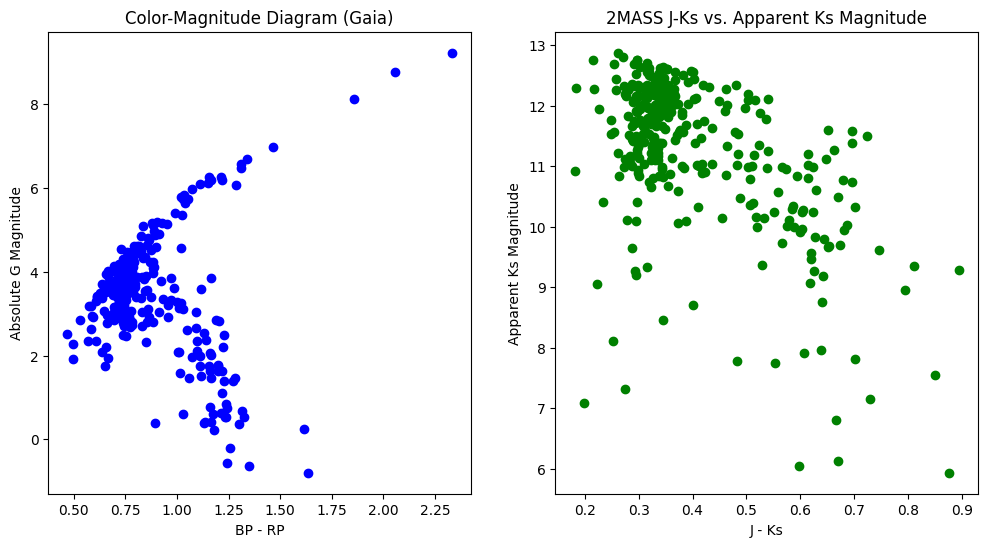

In [2]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Step 1: ADQL query to download stars within 1 degree of Messier 67 brighter than G = 14 from Gaia DR3 and crossmatch with 2MASS
adql_query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.phot_g_mean_mag, 
       gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, 
       tmass.j_m, tmass.h_m, tmass.ks_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr1.tmass_best_neighbour AS xmatch
  ON gaia.source_id = xmatch.source_id
JOIN gaiadr1.tmass_original_valid AS tmass
  ON xmatch.tmass_oid = tmass.tmass_oid
WHERE gaia.phot_g_mean_mag < 14
  AND CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
               CIRCLE('ICRS', 132.825, 11.8, 1)) = 1;
"""


# Step 2: Query Gaia DR3 via astroquery
job = Gaia.launch_job(adql_query)
results = job.get_results()

# Convert the result into a Pandas DataFrame for easier analysis
df = results.to_pandas()

# Step 3: Initial count of stars
initial_count = len(df)

# Step 4: Identify stars with bad 2MASS photometry (ph_qual ≠ 'AAA')
bad_photometry = df[df['ph_qual'] != 'AAA']

# Step 5: Identify stars with negative or non-positive parallaxes
bad_parallax = df[df['parallax'] <= 0]

# Step 6: Apply the quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes)
filtered_df = df[(df['ph_qual'] == 'AAA') & (df['parallax'] > 0)]

# Step 7: After applying the cuts, determine how many stars remain
filtered_count = len(filtered_df)

# Step 8: Generate a figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# (a) Gaia BP-RP vs. absolute G magnitude
# Calculate absolute G magnitude using M_G = G + 5 * log10(parallax / 1000) + 5
filtered_df['absolute_g'] = filtered_df['phot_g_mean_mag'] + 5 * np.log10(filtered_df['parallax'] / 1000) + 5
bp_rp = filtered_df['phot_bp_mean_mag'] - filtered_df['phot_rp_mean_mag']

ax1.scatter(bp_rp, filtered_df['absolute_g'], color='blue')
ax1.set_xlabel('BP - RP')
ax1.set_ylabel('Absolute G Magnitude')
ax1.set_title('Color-Magnitude Diagram (Gaia)')

# (b) 2MASS J-Ks vs. apparent Ks magnitude
j_ks = filtered_df['j_m'] - filtered_df['ks_m']

ax2.scatter(j_ks, filtered_df['ks_m'], color='green')
ax2.set_xlabel('J - Ks')
ax2.set_ylabel('Apparent Ks Magnitude')
ax2.set_title('2MASS J-Ks vs. Apparent Ks Magnitude')

# Ensure 'figures' directory exists and save the figure
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/cmds_M67.png', dpi=200)

# Step 9: Display the results
print(f"Initial number of stars: {initial_count}")
print(f"Stars with bad 2MASS photometry: {len(bad_photometry)}")
print(f"Stars with negative/non-positive parallaxes: {len(bad_parallax)}")
print(f"Number of stars remaining after cuts: {filtered_count}")
